In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime as dt
import importlib

import aux_funcs as aux

## data import

In [2]:
train = aux.read_train_data()

train.csv read in 9.7 s
Mem. usage decreased to 289.19 Mb (53.1% reduction)
(20216100, 11)
   building_id  meter  timestamp  meter_reading  hour  day  year  weeknumber  \
0            0      0 2016-01-01            0.0     0    1  2016          53   
1            1      0 2016-01-01            0.0     0    1  2016          53   
2            2      0 2016-01-01            0.0     0    1  2016          53   
3            3      0 2016-01-01            0.0     0    1  2016          53   
4            4      0 2016-01-01            0.0     0    1  2016          53   

   weekday  month  log_meter_reading  
0        4      1                0.0  
1        4      1                0.0  
2        4      1                0.0  
3        4      1                0.0  
4        4      1                0.0  


In [3]:
building = aux.read_building_data()

building_metadata.csv read in 0.1 s
Mem. usage decreased to  0.03 Mb (60.3% reduction)
(1449, 7)
   site_id  building_id primary_use  square_feet  year_built  floor_count  \
0        0            0   Education         7432      2008.0          NaN   
1        0            1   Education         2720      2004.0          NaN   
2        0            2   Education         5376      1991.0          NaN   
3        0            3   Education        23685      2002.0          NaN   
4        0            4   Education       116607      1975.0          NaN   

   log_square_feet  
0         8.913550  
1         7.908387  
2         8.589700  
3        10.072597  
4        11.666565  


In [4]:
weather_train = aux.read_weather_train_data()

weather_train.csv read in 0.3 s
Mem. usage decreased to  3.07 Mb (68.1% reduction)


### join

In [5]:
tbw = train.join(building, on='building_id', rsuffix = 'r')

tbw.drop(columns=['year_built','floor_count','building_idr'],inplace=True)

In [6]:
tbw = pd.merge(tbw, weather_train,left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
tbw.head()

,building_id,meter,timestamp,meter_reading,hour,day,year,weeknumber,weekday,month,...,primary_use,square_feet,log_square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,1,2016,53,4,1,...,Education,7432,8.913550,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,1,2016,53,4,1,...,Education,2720,7.908387,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,1,2016,53,4,1,...,Education,5376,8.589700,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,1,2016,53,4,1,...,Education,23685,10.072597,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,1,2016,53,4,1,...,Education,116607,11.666565,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


## fit adjust

In [7]:
use_list = np.unique(building['primary_use'])
meter_list = np.arange(0,4)
features_list=['weeknumber','weekday','hour','log_square_feet','air_temperature']

In [10]:
import pickle
# untuned tree of trees
with open('tree_of_trees_191023.pkl','rb') as treefile:
    dtrs = pickle.load(treefile)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [12]:
res = pd.read_csv('tree_of_trees_notune.csv')
res.head()

,use,meter,n_data,R2,mse
0,Education,0,4577522,0.973049,0.084164
1,Education,1,1812418,0.900901,0.669636
2,Education,2,1125729,0.830636,1.235509
3,Education,3,606440,0.845317,1.008202
4,Entertainment/public assembly,0,1505695,0.973836,0.084488


In [14]:
res_sort = res.sort_values(by='mse', ascending=False)
res_sort.head()

,use,meter,n_data,R2,mse
46,Technology/science,3,8748,0.550210,4.491899
7,Entertainment/public assembly,3,138796,0.628268,3.254709
42,Services,2,17564,0.898381,1.785532
6,Entertainment/public assembly,2,240055,0.686833,1.653541
26,Office,3,289434,0.777705,1.566249


In [16]:
# initialise new variables
new_dtrs = dtrs
new_res_sort = res_sort

In [17]:
new_res_sort['min_samples_leaf'] = 0
new_res_sort['min_samples_split'] = 0

### loop

In [118]:
k = 10 # tree to fix
curr = res_sort.iloc[k]
curr

use                    Office
meter                       2
n_data                 674002
R2                   0.851947
mse                    1.0056
min_samples_leaf            0
min_samples_split           0
Name: 25, dtype: object

In [119]:
# extract by primary use and meter value
sub_df = tbw[(tbw['primary_use']== curr['use']) & (tbw['meter']==curr['meter'])]

X=sub_df[features_list]
y=sub_df['log_meter_reading']

#eliminate points with no temperature
cond = ~X['air_temperature'].isnull() 
print(sum(cond),'datapoints')
X = X[cond]
y = y[cond]

674002 datapoints


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   20.0s finished


{'min_samples_leaf': 250, 'min_samples_split': 4}


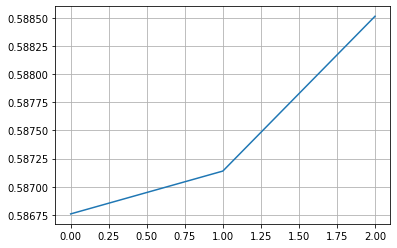

In [122]:
from sklearn.model_selection import GridSearchCV
params = {'min_samples_leaf':[150,200,250], 'min_samples_split':[4]}

dtr_tune = DecisionTreeRegressor()
gscv = GridSearchCV(dtr_tune, params, cv=5, verbose=1)

gscv.fit(X, y)

print(gscv.best_params_)

mts= np.array(gscv.cv_results_['mean_test_score'])
plt.plot(mts);
plt.grid()
plt.show()

In [123]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.75, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

# fit
print('Fitting model...')
t0 = time()
dtr = DecisionTreeRegressor(min_samples_leaf = gscv.best_params_['min_samples_leaf'],\
                            min_samples_split=gscv.best_params_['min_samples_split'])
dtr.fit(X_train,y_train)
print('Fit in {:.1f}s'.format(time()-t0) )

print('Validating...')
# predict
pred = dtr.predict(X_test)

# validate model
R2 = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
print('R2 :', R2)
print('MSE :', mse)


X_train shape:  (505501, 5)
X_test shape:  (168501, 5)
Fitting model...
Fit in 1.7s
Validating...
R2 : 0.8293851649520467
MSE : 1.1588486616428475


In [124]:
#remind where we started from
res_sort.iloc[k,:]

use                    Office
meter                       2
n_data                 674002
R2                   0.851947
mse                    1.0056
min_samples_leaf            0
min_samples_split           0
Name: 25, dtype: object

In [125]:
# attach results to table
new_res_sort.iloc[k,3] = R2
new_res_sort.iloc[k,4] = mse
new_res_sort.iloc[k,5] = gscv.best_params_['min_samples_leaf']
new_res_sort.iloc[k,6] = gscv.best_params_['min_samples_split']
new_res_sort.head(k+1)


,use,meter,n_data,R2,mse,min_samples_leaf,min_samples_split
46,Technology/science,3,8748,0.702061,2.975416,300,4
7,Entertainment/public assembly,3,138796,0.656662,3.006102,300,4
42,Services,2,17564,0.886513,1.994059,50,4
6,Entertainment/public assembly,2,240055,0.802099,1.044930,50,4
26,Office,3,289434,0.737647,1.848495,525,4
36,Public services,3,78928,0.817184,1.312920,150,4
18,Lodging/residential,2,360378,0.814392,1.142239,100,4
28,Other,1,22623,0.871341,1.225100,80,4
2,Education,2,1125729,0.853747,1.066914,100,4
3,Education,3,606440,0.859646,0.914806,80,4


In [126]:
# attach new tree
new_dtrs[new_res_sort.index[k]] = dtr
new_dtrs[new_res_sort.index[k]]

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=250,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

## save files

In [127]:
new_res_sort.to_csv('tuned_tree_of_trees_perf_v02.csv')

In [129]:
with open('tuned_tree_of_trees_191026_v02.pkl','ab') as treefile:
    pickle.dump(new_dtrs, treefile)

In [128]:
for tr in new_dtrs:
    print(type(tr))

<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
